In [1]:
source("~/common//scripts/loadCommonPackagesR.r")
library(rjson)

In [2]:
setwd("/NAS392047/projects/yujw/2021.05.21.dingsheng/2Cell.induce/")

In [33]:
readComputeMatrixResult<-function(dfPath,offset=6){
  library(rjson)
  library(tidyverse)
  
  df<-read_tsv(file=dfPath,col_names=F,col_types=cols(),skip=1)
  metadata<-readLines(gzfile(dfPath),1)%>%str_remove("^@")%>%fromJSON(json_str=.)
  dfSplited<-list()
  for(i in 1:length(metadata$sample_labels)){
    dfSplited<-c(
      dfSplited,
      df[
        (offset+1  +  metadata$sample_boundaries[i]):
        (offset  +  metadata$sample_boundaries[i+1])
      ]%>%list
    )
  }
  names(dfSplited)<-metadata$sample_labels
  return(dfSplited)
}

In [85]:
dfList<-readComputeMatrixResult("computeMatrix/allStage.Up.matrix.gz")

In [86]:
ownData<-dfList[c("mESC","TLC")]
xieweiData<-dfList[!names(dfList) %in% c("mESC","TLC")]

In [87]:
t1<-reduce(xieweiData,cbind)

In [88]:
t1%>%as.matrix%>%max

[1] 72.5897

In [146]:
get98Percentile<-function(dfList){
  bigMtx<-reduce(dfList,cbind)
  return(quantile(bigMtx%>%as.matrix%>%colMeans,1))
}

In [147]:
own98<-get98Percentile(ownData)
xiewei98<-get98Percentile(xieweiData)

In [148]:
xiewei98

100% 
4.581546

In [149]:
plotLinePlot<-function(a98,df,color="#D43F3A"){
  df<-df%>%colMeans%>%as.data.frame%>%mutate(relativeCoordinate=row_number())
  names(df)<-c("signal","relativeCoordinate")
  breaks<-a98*1.0*seq(0,1,0.25)
  p1<-ggplot(df)+
  geom_line(
    aes(x=relativeCoordinate,y=signal),
    size=0.8,
    color=color
  )+
  scale_y_continuous(
    breaks = breaks,
    labels = breaks%>%sprintf(fmt = "%.1f"),
    limits = c(breaks[1],breaks%>%tail(1))
  )+
  scale_x_continuous(
    breaks = c(0,5000,10000),
    labels = c("-5k","0","+5k")
  )+
  theme_classic()
}

In [150]:
ownPlotList<-lapply(ownData,function(x){plotLinePlot(own98,x)})

In [151]:
xieweiPlotList<-lapply(xieweiData,function(x){plotLinePlot(xiewei98,x)})

In [152]:
allPlotList<-c(ownPlotList,xieweiPlotList)

In [153]:
allPlotList<-mapply(function(p1,title){p1+labs(title=title)}, allPlotList,dfList%>%names,SIMPLIFY = FALSE)

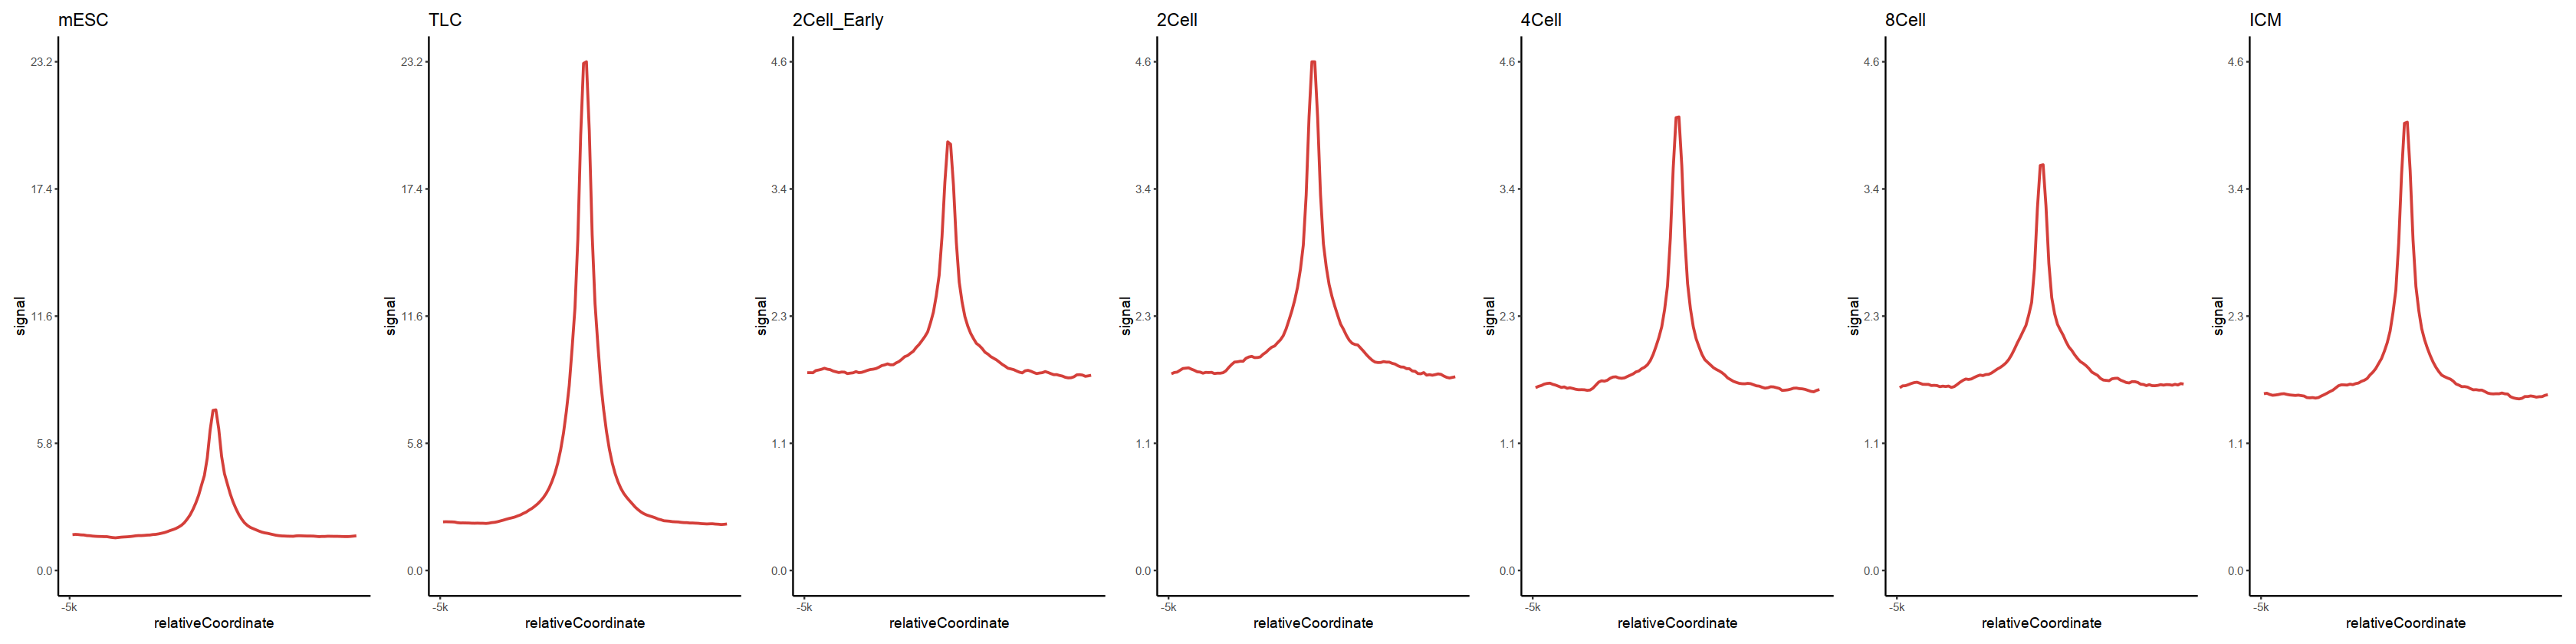

In [154]:
options(repr.plot.width=28)
allPlotList%>%wrap_plots(nrow=1)

In [155]:
allPlotList%>%wrap_plots%>%ggsave(filename="up.linePlot.pdf",w=9,h=9)